In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using DifferentialEquations, Plots, PhasorNetworks

In [3]:
using Lux, NNlib, Zygote, ComponentArrays, Optimisers

In [4]:
using Interpolations

In [5]:
using Random: Xoshiro

In [6]:
phases = -1.0:0.1:1.0 |> collect
n_in = length(phases)

21

In [7]:
sa = SpikingArgs()
train = phase_to_train(phases, spk_args=sa, repeats=1)

Spike Train: (21,) with 21 spikes.

In [8]:
using PhasorNetworks: gaussian_kernel

In [9]:
function cfn(train::SpikeTrain, t::Real, spk_args::SpikingArgs; sigma::Real = 9.0)

    #add currents into the active synapses
    current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
    impulses = current_kernel(train.times)

    return impulses
end

cfn (generic function with 1 method)

In [10]:
cfn(train, 0.5, sa)

21-element Vector{Float64}:
 3.6808558548018004e-272
 1.3753667993264065e-220
 1.9151695967140057e-174
 9.938364413483684e-134
 1.921947727823849e-98
 1.3851193699226017e-68
 3.720075976020836e-44
 3.7233631217504573e-25
 1.388794386496412e-11
 0.0019304541362277128
 1.0
 0.001930454136227687
 1.388794386496412e-11
 3.7233631217504573e-25
 3.7200759760209417e-44
 1.3851193699226017e-68
 1.92194772782374e-98
 9.938364413483684e-134
 1.9151695967140057e-174
 1.375366799326641e-220
 3.6808558548018004e-272

In [11]:
current_fn = t -> cfn(train, t, sa)

#4 (generic function with 1 method)

In [12]:
current_sample = stack(current_fn.(0.0:0.001:1.0), dims=1);

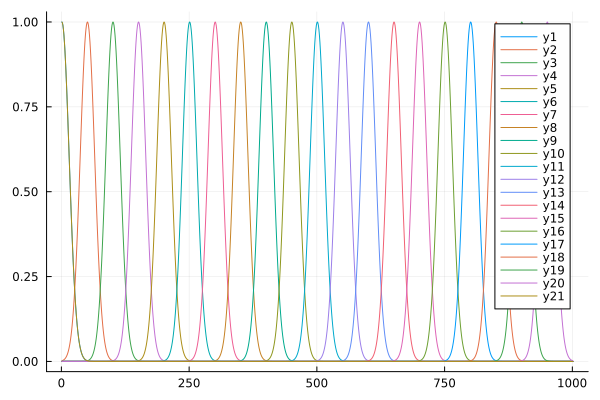

In [13]:
plot(current_sample)

In [14]:
ode_fn = Chain(Dense(n_in => n_in))

Dense(21 => 21)     # 462 parameters

In [15]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [16]:
in_ps, in_st = Lux.setup(rng, ode_fn)

((weight = Float32[-0.034407683 0.033833884 … -0.24778546 0.29199758; -0.24675442 -0.34743497 … 0.120002545 0.33507735; … ; -0.30658105 0.07079895 … -0.060400184 -0.31799373; 0.071049556 0.102035664 … -0.22994705 -0.15559468], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), NamedTuple())

In [17]:
smp = current_fn(0.0);

In [18]:
size(smp)

(21,)

In [19]:
smp1, _ = ode_fn(smp, in_ps, in_st)

([0.257655213766016, 0.08765221532036091, -0.13256490755839434, -0.3593759451363434, 0.30607213518641807, -0.37878644067502654, 0.10280439089258442, 0.055457599117088474, -0.526273975720372, -0.2783401689641056  …  0.02093992281535921, 0.11071689616833413, 0.08527098251816947, -0.0362881337801601, 0.13193465202053514, -0.18967310925392858, 0.008345381662816176, -0.02412290285355262, -0.6244381063456668, -0.08434814542350348], NamedTuple())

In [20]:
smp1 |> size

(21,)

In [21]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                x -> complex_to_angle(Array(x)),
                PhasorDense(21 => 21),)

Chain(
    layer_1 = PhasorODE(
        model = Dense(21 => 21),        # 462 parameters
    ),
    layer_2 = WrappedFunction(#8),
    layer_3 = PhasorDense((21, 21)),    # 462 parameters
)         # Total: 924 parameters,
          #        plus 0 states.

In [22]:
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (weight = Float32[-0.2151638 0.3665407 … -0.23877338 -0.087368436; -0.36821428 -0.24055284 … 0.24381015 0.31122464; … ; 0.21464978 -0.055422254 … 0.2479661 0.15970698; -0.10953547 0.29423267 … 0.2114452 -0.12547596], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.24133678 0.04167493 … -0.10672306 0.19347268; 0.049998313 -0.13381687 … 0.20922084 -0.25298816; … ; 0.12727684 0.10234535 … 0.35022178 0.11439906; 0.3622725 0.016393596 … 0.09812723 -0.12995605], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [23]:
out1, st1 = ode_model(current_fn, ps, st)

(Float32[-0.4701635; -0.21410662; … ; -0.07916371; -0.13336661;;], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [24]:
u1 = Array(out1)

21×1 Matrix{Float32}:
 -0.4701635
 -0.21410662
  0.10580951
  0.26606932
  0.099375494
  0.24213117
 -0.5895277
 -0.22166912
 -0.12910584
  0.31438994
  0.2422252
  0.010735598
  0.21544378
 -0.22011282
  0.005871872
  0.05705152
  0.045406353
 -0.4280623
  0.2939179
 -0.07916371
 -0.13336661

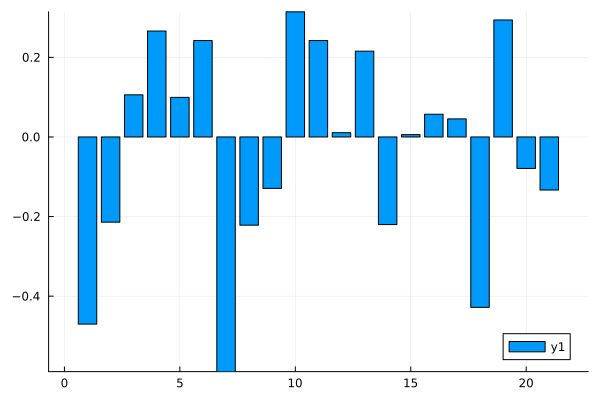

In [25]:
bar(u1)

In [26]:
#calc a gradient through a loss fn on the network

In [27]:
using Statistics: mean

In [28]:
function test_loss(model, ps, st)
    p0, _ = model(current_fn, ps, st)
    err = mean(similarity_loss(p0, reshape(phases, (:,1)),1))
    return err
end

test_loss (generic function with 1 method)

In [29]:
test_loss(ode_model, ps, st)

1.0346836817272718

In [30]:
psa = ComponentArray(ps)

ComponentVector{ComplexF32}(layer_1 = (weight = ComplexF32[-0.2151638f0 + 0.0f0im 0.3665407f0 + 0.0f0im … -0.23877338f0 + 0.0f0im -0.087368436f0 + 0.0f0im; -0.36821428f0 + 0.0f0im -0.24055284f0 + 0.0f0im … 0.24381015f0 + 0.0f0im 0.31122464f0 + 0.0f0im; … ; 0.21464978f0 + 0.0f0im -0.055422254f0 + 0.0f0im … 0.2479661f0 + 0.0f0im 0.15970698f0 + 0.0f0im; -0.10953547f0 + 0.0f0im 0.29423267f0 + 0.0f0im … 0.2114452f0 + 0.0f0im -0.12547596f0 + 0.0f0im], bias = ComplexF32[0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im;;]), layer_2 = ComplexF32[], layer_3 = (weight = ComplexF32[-0.24133678f0 + 0.0f0im 0.04167493f0 + 0.0f0im … -0.10672306f0 + 0.0f0im 0.19347268f0 + 0.0f0im; 0.049998313f0 + 0.0f0im -0.13381687f0 + 0.0f0im … 0.20922084f0 + 0.0f0im -0.25298816f0 + 0.0f0im; … ; 0.12727684f0 + 0.0f0im 0.10234535f0 + 0.0f0im … 0.35022178f0 + 0.0f0im 0.11439906f0 + 0.0f0im; 0.3622725f0 + 0.0f0im 0.016393596f0 + 0.0f0im … 0.09812723f0 + 0.0f0im -0.12995605f0 + 0.0f0im], bias = Com

In [31]:
grads = Zygote.gradient(p -> test_loss(ode_model, p, st), psa)

((layer_1 = (weight = ComplexF32[9.261225f-5 - 0.00015549046f0im 0.00025603003f0 - 0.00025844635f0im … 6.605395f-5 - 0.00043050045f0im 9.261225f-5 - 0.00015549046f0im; 0.00091964443f0 + 0.0006317625f0im 0.0014878575f0 + 0.0016781697f0im … 0.002622099f0 + 0.00057805167f0im 0.00091964443f0 + 0.0006317625f0im; … ; -0.005339677f0 + 0.014792172f0im -0.017585969f0 + 0.026268758f0im … 0.0014573762f0 + 0.03781812f0im -0.005339677f0 + 0.014792172f0im; 0.021803576f0 - 0.026666472f0im 0.05545899f0 - 0.04145376f0im … 0.024533814f0 - 0.079180695f0im 0.021803576f0 - 0.026666472f0im], bias = ComplexF32[-0.0003156736f0 - 0.00017165157f0im; 0.0011818957f0 - 0.0018735657f0im; … ; 0.029761001f0 + 0.009444063f0im; -0.054597687f0 - 0.0411841f0im;;]), layer_2 = ComplexF32[], layer_3 = (weight = ComplexF32[0.02145715f0 - 0.00838396f0im -0.009754464f0 - 0.020869847f0im … 0.022657592f0 - 0.004163373f0im -0.019983793f0 + 0.011460722f0im; 0.009020238f0 + 0.04434055f0im 0.0035658027f0 + 0.03091219f0im … 0.0080681

In [32]:
withgradient(p -> test_loss(ode_model, p, st), psa)

(val = 0.9932794320887222, grad = ((layer_1 = (weight = ComplexF32[9.261225f-5 - 0.00015549046f0im 0.00025603003f0 - 0.00025844635f0im … 6.605395f-5 - 0.00043050045f0im 9.261225f-5 - 0.00015549046f0im; 0.00091964443f0 + 0.0006317625f0im 0.0014878575f0 + 0.0016781697f0im … 0.002622099f0 + 0.00057805167f0im 0.00091964443f0 + 0.0006317625f0im; … ; -0.005339677f0 + 0.014792172f0im -0.017585969f0 + 0.026268758f0im … 0.0014573762f0 + 0.03781812f0im -0.005339677f0 + 0.014792172f0im; 0.021803576f0 - 0.026666472f0im 0.05545899f0 - 0.04145376f0im … 0.024533814f0 - 0.079180695f0im 0.021803576f0 - 0.026666472f0im], bias = ComplexF32[-0.0003156736f0 - 0.00017165157f0im; 0.0011818957f0 - 0.0018735657f0im; … ; 0.029761001f0 + 0.009444063f0im; -0.054597687f0 - 0.0411841f0im;;]), layer_2 = ComplexF32[], layer_3 = (weight = ComplexF32[0.02145715f0 - 0.00838396f0im -0.009754464f0 - 0.020869847f0im … 0.022657592f0 - 0.004163373f0im -0.019983793f0 + 0.011460722f0im; 0.009020238f0 + 0.04434055f0im 0.0035658

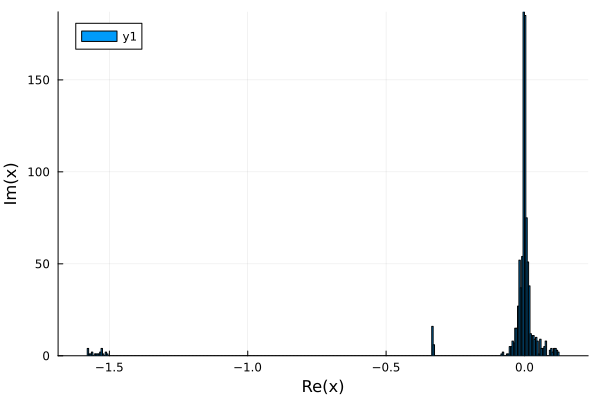

In [33]:
histogram(grads[1])

In [34]:
opt_state = Optimisers.setup(Adam(3e-4), psa)

Leaf(Adam(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], (0.9+0.0im, 0.999+0.0im)))

In [35]:
losses = []

Any[]

In [36]:
for i in 1:100
    lossval, gs = withgradient(p -> test_loss(ode_model, p, st), psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

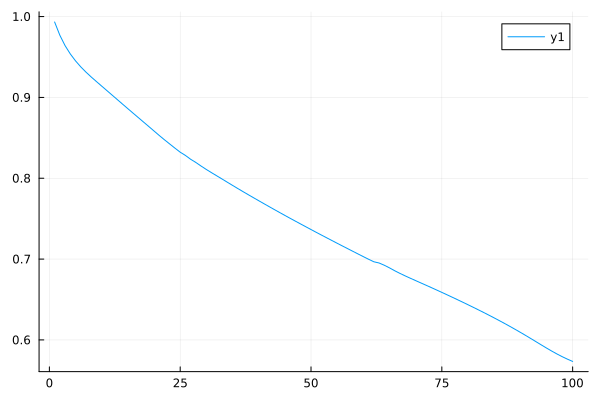

In [37]:
plot(losses)

In [38]:
for i in 1:1000
    lossval, gs = withgradient(p -> test_loss(ode_model, p, st), psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

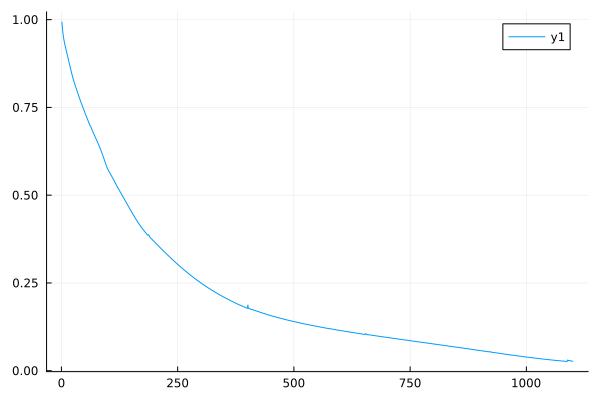

In [39]:
plot(losses)

In [40]:
test_loss(ode_model, psa, st)

0.013918353145548679

In [41]:
out2, _ = ode_model(current_fn, psa, st)

(Float32[0.9902521; -0.9225556; … ; 0.84096396; -0.7790495;;], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

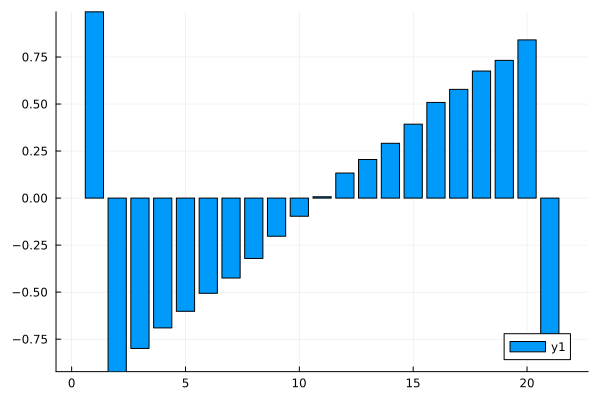

In [42]:
bar(out2)

In [43]:
similarity(vec(out2), phases)

1-element Vector{Float64}:
 0.9860816468544513